In [1]:
import os

# for demo, set working directory to root
os.chdir("..")

import pandas as pd
import numpy as np
from gridpred.evaluate.metrics import evaluate, pai, pei, rri
from gridpred.model.random_forest import RandomForestGridPred
from gridpred.plotting import visualize_predictions
from gridpred.prediction import GridPred

### Defining a `GridPred` object

The primary goal of the `GridPred` library is to abstract away many of the time-consuming tasks for setting up a prediction dataset. These tasks typically involve defining a spatial grid, merging points to the grid, defining spatial features (e.g. grid counts, distance to nearest feature), and splitting the data for use in a prediction model.

The core `GridPred` function requires at a minimum to provide a path to a .csv file containing the longitude and latitude of crime incidents, as well as the name of a field for a date variable. If a spatial region shapefile is not provided, the convex hull of input crime points is used as the region.

In [2]:
# define the inputs
crime_data = "input/hartford_robberies.csv"
predictor_features = "input/hartford_pois.csv"
region_shapefile = "input/hartford.shp"

# define variable names
time_var = "year"
features_var = "types"

# spatial projections
# includes the coordinate reference system of the input crime data
# as well as a desired projection for all spatial objects
input_crime_crs = 3508
projected_crs = 3508

# size of the grid to use (in units based on projection)
grid_size = 400


# This initalizes the GridPred class with the specified data
gridpred = GridPred(
    input_crime_data=crime_data,
    input_features_data=predictor_features,
    input_study_region=region_shapefile,
    crime_time_variable=time_var,
    features_names_variable=features_var,
    input_crs=input_crime_crs,
)

The `prepare_data` function takes all of our inputs and creates a tabular dataset `X` that can be used in a prediction model. Printing the object below shows that we have the counts of 2017 robberies, as well as the nearest distance to a variety of potentially criminogenic features (gas stations, bars, night clubs, etc...). `y` is the hold-out evaluation set (by default, it is the most recent time value)

In [3]:
# This generates the input to the regression model
gridpred.prepare_data(
    grid_cell_size=grid_size,
    do_projection=True,
    projected_crs=projected_crs
)

# Look at top 5 values in the predictor matrix
# is stored as a class object `X`
gridpred.X.head(5).round(2)

,events_2017,liquor_store,bar,gas_station,restaurant,pharmacy,night_club,x,y
231,0,641.01,648.26,2878.30,4489.75,5964.84,9438.41,1010113.10,824653.91
308,0,254.13,255.45,2915.07,4217.04,5942.46,9098.14,1010511.83,824679.61
154,0,970.47,979.03,2892.32,4732.11,6006.24,9726.21,1009781.55,824629.96
232,0,751.07,744.97,2534.31,4231.56,5618.71,9241.02,1010119.00,825000.00
309,0,467.13,449.17,2605.54,3962.67,5622.69,8907.88,1010519.00,825000.00


### Predictor Models

For the actual modelling portion, users can specify *any* model that accepts tabular format. For simplicity we can just use a `RandomForestGridPred` which is primarily a wrapper around a `scikit-learn` Random Forest model with some convience functions added on top. But you could just as easily import any other model and run them separately.

In [4]:
# very basic demo model workflow
# can replace with xgboost or whatever model
X = gridpred.X
y = gridpred.y

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(X, y)
y_pred = rf.predict(X)

In [5]:
# print feature importances
# TODO: in future, can be logged and plotted
importances = pd.Series(rf.get_feature_importances(), index=X.columns)
print(importances.sort_values(ascending=False))

events_2017     0.270618
liquor_store    0.240522
pharmacy        0.089078
restaurant      0.084547
gas_station     0.081187
night_club      0.072135
bar             0.071431
y               0.053238
x               0.037243
dtype: float64


In [6]:
# plotting
region_grid = gridpred.region_grid

### Evaluation Metrics

We can compute a number of standard crime-prediction metrics like the Predictive Accuracy Index (PAI), the Predective Effecicency Index (PEI), and the Rate Recapture Index (RRI) which are already pre-defined in the library. You can pass in a dict of metrics or a simple list of the functions on their own.

Furthermore, you can pass any valid function to `evaluate`. You can also define any other arbitrary set of functions as long as it takes the values `y_true` and `y_pred` as an argument. An example below shows a custom function defined for computing the hit rate (proportion of total crimes in the top x% of predicted hot spots).

In [7]:
# Pass a dict of pre-defined library metrics
METRICS = {'PAI': pai, 'PEI': pei, 'RRI': rri}

print(
    evaluate(
        y_true=gridpred.eval,
        y_pred=y_pred,
        metrics=METRICS,
        region_grid=region_grid,
        round_digits=2
    )
)


{'PAI': 14.21, 'PEI': 0.49, 'RRI': 14.96}


In [8]:
# function for hit rate, add to dict and evaluate alongside others
def hit_rate(y_true, y_pred, top_fraction=0.01, **kwargs):

    # ensure arrays
    y_true = y_true.values
    k = int(np.ceil(len(y_pred) * top_fraction))

    # top predicted cells
    idx = np.argsort(y_pred)[-k:]

    return y_true[idx].sum() / y_true.sum() if y_true.sum() > 0 else 0.0


In [9]:
print(
    evaluate(
        y_true=gridpred.eval,
        y_pred=y_pred,
        metrics=[pai, hit_rate],
        region_grid=region_grid,
        round_digits=2,
    )
)

{'pai': 14.21, 'hit_rate': 0.15}


## Generating Final Predictions

Once you are satisfied with the performance of your model on the evaluation set, you should then proceed to make a 'final' prediction for yet-unseen future data. The `prep_data` function creates a separate set of features to fit the final model using all available time periods for grid count predictions, and the most recent time period as the target.

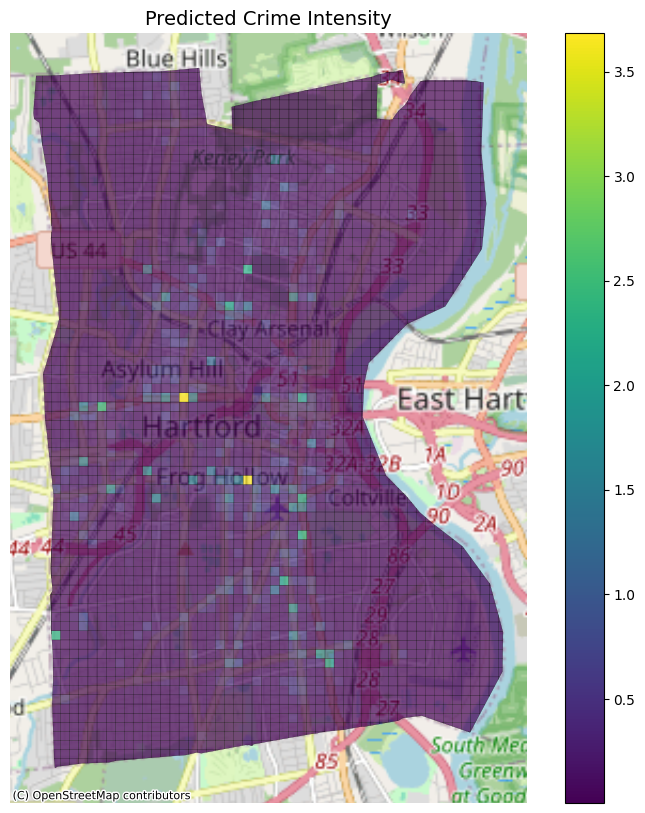

In [10]:
# Use tested model parameters from step above
# then predict below:

Xfinal = gridpred.X_final
yfinal = gridpred.y_final

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(Xfinal, yfinal)
y_pred = rf.predict(Xfinal)

# plot the final prediction
region_grid = gridpred.region_grid
visualize_predictions(region_grid, y_pred)

In [20]:
evaldf = Xfinal.copy()
evaldf['pred'] = y_pred

In [21]:
evaldf

,events_2017,events_2018,liquor_store,bar,gas_station,restaurant,pharmacy,night_club,x,y,pred
231,0,0,641.012193,648.259475,2878.302425,4489.752609,5964.843716,9438.408102,1.010113e+06,824653.906139,0.012807
308,0,0,254.127125,255.451323,2915.067412,4217.041565,5942.459725,9098.137158,1.010512e+06,824679.610618,0.043013
154,0,0,970.472852,979.033256,2892.318663,4732.113417,6006.238041,9726.212636,1.009782e+06,824629.961955,0.018383
232,0,0,751.074276,744.971937,2534.308457,4231.560236,5618.711677,9241.019267,1.010119e+06,825000.000000,0.011095
309,0,0,467.127742,449.166710,2605.537806,3962.671507,5622.688736,8907.878004,1.010519e+06,825000.000000,0.019617
...,...,...,...,...,...,...,...,...,...,...,...
2691,0,0,4730.705309,2551.233326,3331.788398,2552.851868,5812.949988,5453.028408,1.022519e+06,853800.000000,0.000960
2615,0,0,4927.305137,2816.338331,3814.044154,2816.338331,6101.374110,5792.751890,1.022128e+06,854158.048177,0.000960
2538,0,0,4721.983782,3212.676470,3960.570272,3212.676470,5915.116989,5761.512277,1.021731e+06,854117.195448,0.000961
2692,0,0,5123.586225,2423.623513,3701.030190,2423.623513,6200.311797,5846.343066,1.022523e+06,854194.263770,0.000960


In [23]:
from pyproj import Transformer

# Define the transformer: from EPSG:3508 to EPSG:4326
# 'always_xy=True' ensures we handle (lon, lat) order correctly
transformer = Transformer.from_crs("EPSG:3508", "EPSG:4326", always_xy=True)

x = 1015319.0
y = 840600.0

lon, lat = transformer.transform(x, y)

print(f"Latitude: {lat}")
print(f"Longitude: {lon}")

Latitude: 41.76808552571839
Longitude: -72.69384570776899
